In [1]:
!pip install tensorflow tensorflow-gpu tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


## Learn the use of widgets

In [4]:
# Create a function that updates a plot based on the slider's value
def update_plot(amplitude):
    x = np.linspace(0, 2 * np.pi, 100)
    y = amplitude * np.sin(x)
    plt.plot(x, y)
    plt.ylim(-2, 2)
    plt.title(f'Sine Wave with Amplitude {amplitude}')
    plt.show()

# Create a slider widget
amplitude_slider = widgets.FloatSlider(
    value=1.0,      # Initial value
    min=0.1,        # Minimum value
    max=2.0,        # Maximum value
    step=0.1,       # Step size
    description='Amplitude:',
    continuous_update=False
)

# Use display to show the widget
display(amplitude_slider)

# Use the interact function to link the slider to the update_plot function
widgets.interact(update_plot, amplitude=amplitude_slider)


FloatSlider(value=1.0, continuous_update=False, description='Amplitude:', max=2.0, min=0.1)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Amplitude:', max=2.0, min=0…

<function __main__.update_plot(amplitude)>

In [5]:
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [6]:
!pip install tensorflow_datasets

In [7]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [8]:
#use the tesorflow dataset api to bring the data source
ds, info = tfds.load('fashion_mnist', split='train', with_info=True)


In [9]:
print(info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

# Getting familiar with the data using data visualization

In [10]:
import numpy as np

In [11]:
data_iterator=ds.as_numpy_iterator()

In [12]:
(data_iterator.next()['image']).shape

(28, 28, 1)

In [13]:
np.squeeze(data_iterator.next()['image']).shape

(28, 28)

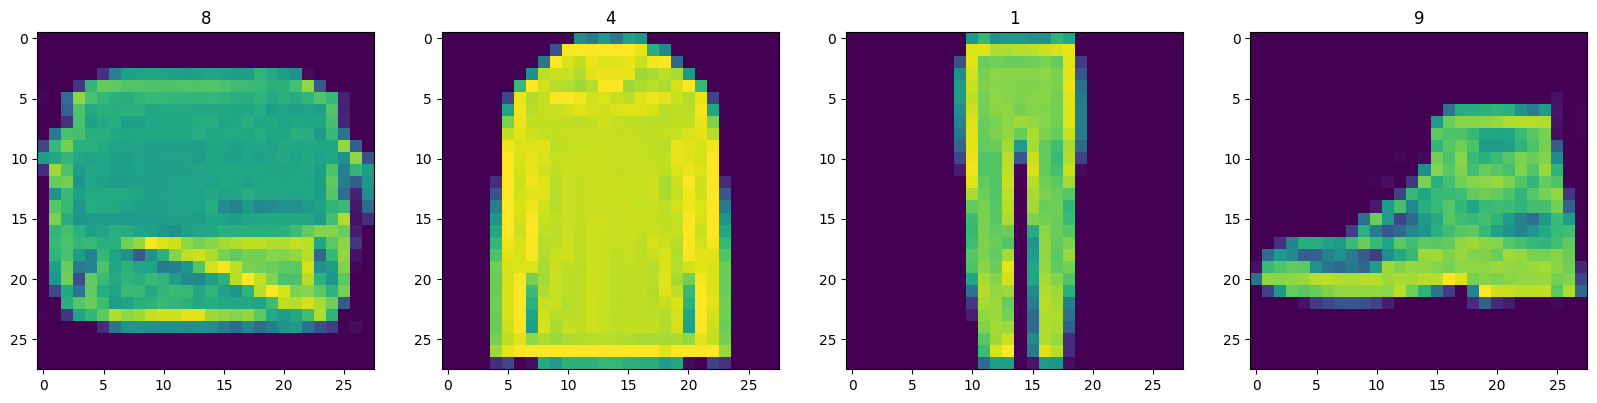

In [14]:
fig,ax=plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample=data_iterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [15]:
def scale_images(data):
    image=data['image']
    return image/255

In [16]:
#reloading the dataset
ds=tfds.load('fashion_mnist',split='train')
#scalong the images usinng the sacle_image function
ds=ds.map(scale_images)
#caching the dataset for that batch
ds=ds.cache()
#sufflling the dataset
ds=ds.shuffle(60000)
#batch into 128 images per sample
ds=ds.batch(128)
#reduce the likelihood of bottlenecking
ds=ds.prefetch(64)

In [17]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten,Reshape, LeakyReLU, Dropout, UpSampling2D

## Build Generator

In [53]:
def build_generator():
    #takes in random values and reshape into 7x7x128
    model=Sequential()
    model.add(Dense(7*7*128,input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    #upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    #upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2))

    #convolutional block 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #convolutional block 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #convolutional layer to get to one channel
    model.add(Conv2D(1,4, padding='same',activation='sigmoid'))



    return model

In [54]:
generator=build_generator()


In [55]:
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

###  generating random images using the generator

In [56]:
images=generator.predict(np.random.randn(4,128,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


In [57]:
images.shape[0]

4

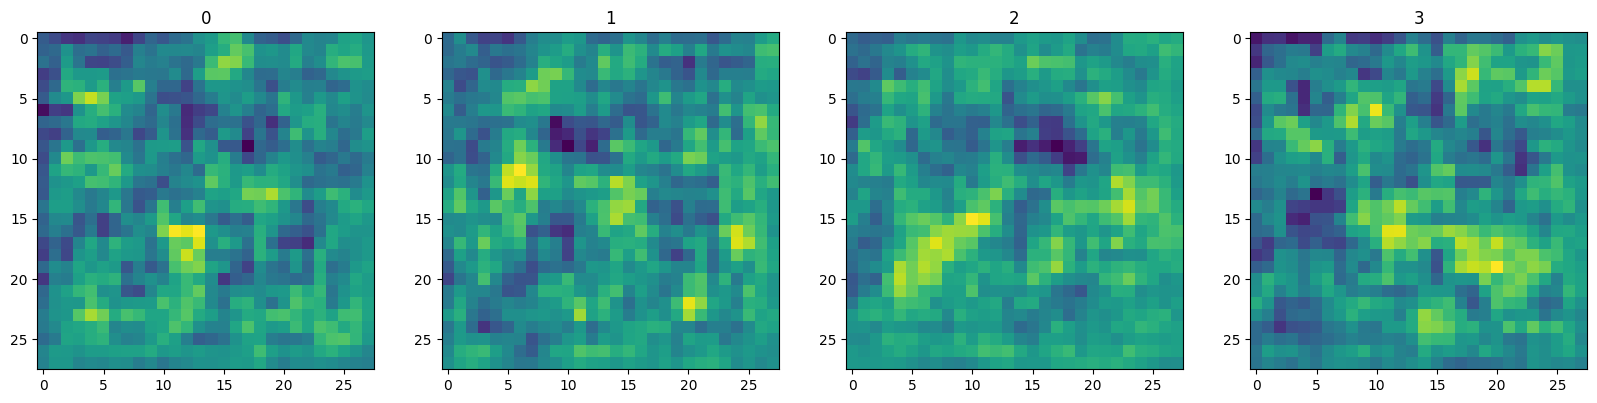

In [58]:
fig,ax=plt.subplots(ncols=4, figsize=(20,10))
for idx,img in enumerate(images):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

## Build Discriminator

In [59]:
def build_discriminator():
    model=Sequential()
    model.add(Conv2D(32,5,input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #second conv block
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #third conv block
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #fourth conv block
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #flattern and pass to dense layer
    model.add(Flatten())
    #model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))

    return model


In [60]:
discriminator= build_discriminator()

In [61]:
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
discriminator.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


array([[0.49814638],
       [0.49813846],
       [0.4981303 ],
       [0.49814188]], dtype=float32)

In [63]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [64]:
g_opt=Adam(learning_rate=0.0001)
d_opt=Adam(learning_rate=0.00001)
g_loss= BinaryCrossentropy()
d_loss=BinaryCrossentropy()


In [65]:
from tensorflow.keras.models import Model

In [66]:
class Fashion(Model):
    def __init__(self, generator,discriminator, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
        #compile with base class
        super().compile(*args,**kwargs)

        #create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self,batch):
        #get the images from tensoflow dataset 'FashionMnist' to fed to the discriminator
        real_images=batch
        #generate a random value of size (batch_size, 128,1) to fed to generator
        fake_images = self.generator(tf.random.normal((128,128,1)),training=False)

        #train the discriminator
        with tf.GradientTape() as d_tape:
            #pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create  label for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the ground truths
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

            # Apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Training the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)),training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training= False)

            # Calculate the loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return{"d_loss":total_d_loss, "g_loss":total_g_loss}




In [67]:
#create the instance of subclassed model
fashgan=Fashion(generator, discriminator)

In [68]:
#compile the model
fashgan.compile(g_opt,d_opt, g_loss, d_loss)

### Build callback


In [69]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [70]:
class ModelMonitor(Callback):
    def __init__(self,num_img=3,latent_dim=128):
        self.num_img=num_img
        self.latent_dim=latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/ganfashion/images', f"generated_img_{epoch}_{i}.png"))

## Training


In [71]:
hist = fashgan.fit(ds, epochs=5, callbacks=[ModelMonitor()] )

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 126s 241ms/step - d_loss: 0.5510 - g_loss: 0.9391
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 124s 220ms/step - d_loss: 0.6943 - g_loss: 0.7556
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 219ms/step - d_loss: 0.6946 - g_loss: 0.6812
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - d_loss: 0.6803 - g_loss: 0.7234
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - d_loss: 0.6899 - g_loss: 0.6591


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

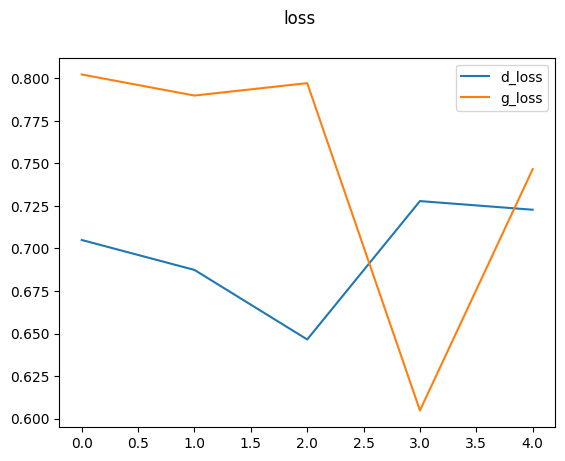

In [73]:
plt.suptitle('loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()